***
## notebook config

In [1]:
ON_COLAB = True
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

Mounted at /content/drive
              total        used        free      shared  buff/cache   available
Mem:            35G        1.0G         32G        1.1M        1.9G         33G
Swap:            0B          0B          0B


In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

 92% 285M/309M [00:01<00:00, 230MB/s]
100% 309M/309M [00:01<00:00, 228MB/s]
total 518M
drwxr-xr-x 1 root root 4.0K Aug 21 22:39 .
-rw-r--r-- 1 root root 5.7M Aug 21 22:39 validation_seed23.csv
-rw-r--r-- 1 root root 5.7M Aug 21 22:39 validation_seed2.csv
-rw-r--r-- 1 root root 5.7M Aug 21 22:39 validation_seed19.csv
-rw-r--r-- 1 root root 5.7M Aug 21 22:39 validation_seed17.csv
-rw-r--r-- 1 root root 169K Aug 21 22:39 unpredictable.csv
-rw-r--r-- 1 root root  78M Aug 21 22:39 train_data.parquet
-rw-r--r-- 1 root root  78M Aug 21 22:39 train.parquet
-rw-r--r-- 1 root root 4.9M Aug 21 22:39 test_data.csv
-rw-r--r-- 1 root root 223M Aug 21 22:39 test.parquet
-rw-r--r-- 1 root root 3.3M Aug 21 22:39 skus_for_assess.csv
-rw-r--r-- 1 root root  16M Aug 21 22:39 scales.csv
-rw-r--r-- 1 root root  94M Aug 21 22:39 sample_submission.csv
drwx------ 5 root root 4.0K Aug 21 22:39 drive
drwxr-xr-x 1 root root 4.0K Aug 21 21:55 ..
drwxr-xr-x 1 root root 4.0K Aug 13 13:35 sample_data
drwxr-xr-x 4 roo

In [4]:
SEED = 19
SUB_NBR = "04"

***

In [5]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats
import time

import category_encoders as ce
import lightgbm as lgb
from tqdm import tqdm
from tsforest.forecast import LightGBMForecaster
import optuna

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

In [6]:
def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
class RMSSE():
    def __init__(self, valid_dataframe, scales_dataframe):
        self.valid_dataframe = valid_dataframe
        self.scales_dataframe = scales_dataframe
        self.apply_inverse = False
        if set(["y_mean","y_std"]) <= set(valid_dataframe.columns):
            self.apply_inverse = True

    def _evaluate(self, predictions):
        valid_dataframe = self.valid_dataframe.copy()
        if not self.apply_inverse:  
            valid_dataframe["ypred"] = predictions
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y-ypred)**2")
        else:
            valid_dataframe["ypred"] = valid_dataframe["y_std"]*predictions + valid_dataframe["y_mean"]
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y_raw-ypred)**2")
        mse = valid_dataframe.groupby("sku")["sq_error"].mean().reset_index(name="mse")
        mrg = pd.merge(mse, self.scales_dataframe, how="inner", on="sku")
        return mrg.eval("sqrt(mse)/scale").mean()

    def evaluate(self, ypred, dtrain):
        metric = self._evaluate(ypred)
        return "rmsse", metric, False

In [8]:
def ranked_probability_score(y_true, y_pred):
    """
    Input
        y_true: np.array of shape 30. 
        y_pred: np.array of shape 30. 
    """
    return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def scoring_function(y_true, y_pred):
    """
    Input
        y_true: List of Ints of shape Nx1. Contain the target_stock
        y_pred: List of float of shape Nx30. Contain the prob for each day
    """
    y_true_one_hot = np.zeros_like(y_pred, dtype=np.float64)
    y_true_one_hot[range(len(y_true)), y_true-1] = 1
    return ranked_probability_score(y_true_one_hot, y_pred)

***
## loading data for assessment

In [9]:
scales = pd.read_csv(f"{input_path}/scales.csv")
skus_for_assess = pd.read_csv(f"{input_path}/skus_for_assess.csv")

dataset = (
    pd.read_parquet(f"{input_path}/train.parquet")
    .query("sku in @skus_for_assess.sku")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
dataset

,ds,sku,y,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,available,item_domain_id,item_id,site_id,product_id,product_family_id
0,2021-02-01,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
1,2021-02-02,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
2,2021-02-03,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
3,2021-02-04,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
4,2021-02-05,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29179486,2021-03-27,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
29179487,2021-03-28,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
29179488,2021-03-29,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
29179489,2021-03-30,660915,0,99.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None


In [10]:
dataset.groupby("site_id")["sku"].nunique()

site_id
MLA     43314
MLB    252475
MLM    201008
Name: sku, dtype: int64

***
## model config

In [11]:
categorical_features = {
    "sku": ("y", ce.CatBoostEncoder, None),
    "currency": "default",
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": "default",
    "item_id": ("y", ce.CatBoostEncoder, None),
    "site_id":"default",
    "product_id": ("y", ce.CatBoostEncoder, None),
    "product_family_id": ("y", ce.CatBoostEncoder, None),
}

exclude_features = ["fold","sold_quantity",]

model_params = {
    'objective':'tweedie',
    'tweedie_variance_power':1.6,
    'metric':'None',
    'num_iterations':1000,
    'max_bin': 63,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'learning_rate': 0.02,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'max_cat_threshold': 64,
    'cat_l2': 50,
    'cat_smooth': 50,
    'boost_from_average': False,
    'force_row_wise': True,
    'deterministic':True,
    'seed':SEED,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
    "lags": [1,],
    "window_functions":{
        "mean":   (None, [1,], [3,7,]),
        "std":    (None, [1,], [3,7]),
        "max":    (None, [1,], [3,7]),
    },
}

In [12]:
dataset.loc[:,categorical_features.keys()].isna().sum(axis=0) / len(dataset)

sku                       0.000000
currency                  0.000000
listing_type              0.000000
shipping_logistic_type    0.000000
shipping_payment          0.000000
item_domain_id            0.000000
item_id                   0.000000
site_id                   0.000000
product_id                0.963178
product_family_id         0.883613
dtype: float64

In [13]:
dataset.loc[:,categorical_features.keys()].nunique()

sku                       496797
currency                       4
listing_type                   2
shipping_logistic_type         3
shipping_payment               2
item_domain_id              8156
item_id                   392139
site_id                        3
product_id                 11756
product_family_id          24176
dtype: int64

***
## model training: assessment

------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 154.91 Mb (44.3% reduction)
Mem. usage decreased to 120.20 Mb (51.7% reduction)
Elapsed time for processing features: 0.828243883450826 min.
[LightGBM] [Info] Total Bins 2520
[LightGBM] [Info] Number of data points in the train set: 1242194, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.814573
[100]	valid_0's rmsse: 0.770624
[150]	valid_0's rmsse: 0.765288
Early stopping, best iteration is:
[159]	valid_0's rmsse: 0.765225


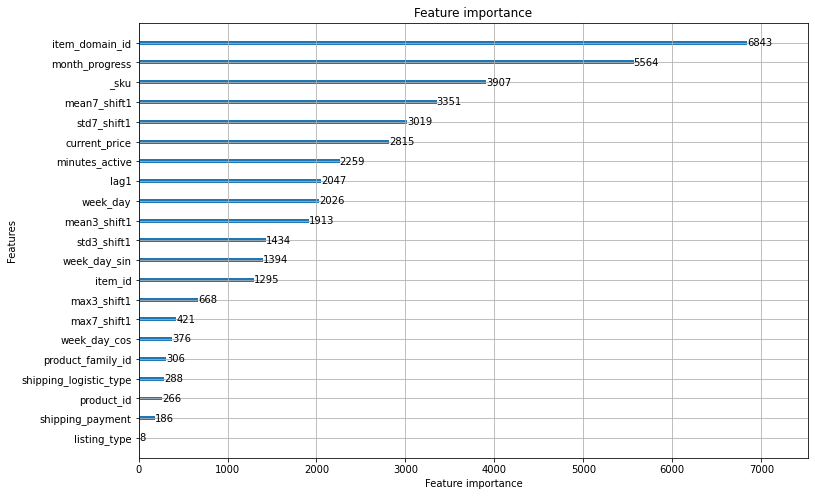

Elapsed time for training the model: 0.8451028863588969 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 992.64 Mb (42.1% reduction)
Mem. usage decreased to 700.67 Mb (51.7% reduction)
Elapsed time for processing features: 4.679625634352366 min.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 7271333, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.859008
[100]	valid_0's rmsse: 0.809425
[150]	valid_0's rmsse: 0.801837
[200]	valid_0's rmsse: 0.801214
Early stopping, best iteration is:
[185]	valid_0's rmsse: 0.80115


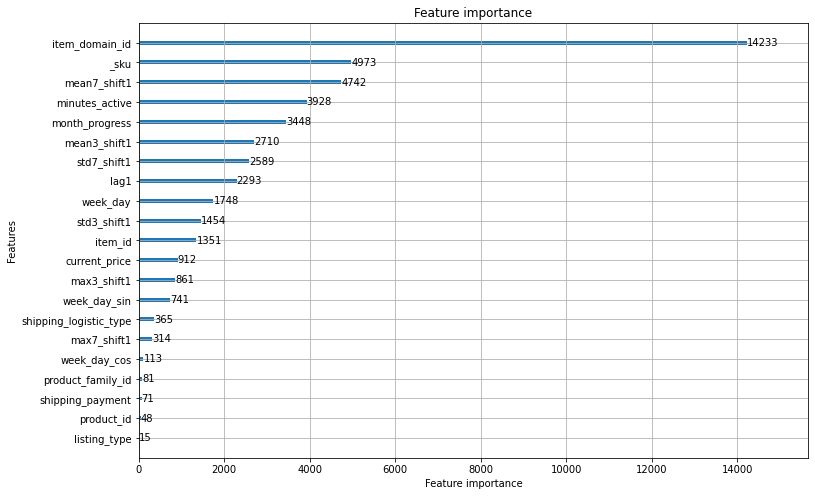

Elapsed time for training the model: 3.4824209094047545 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 693.03 Mb (45.2% reduction)
Mem. usage decreased to 557.84 Mb (51.7% reduction)
Elapsed time for processing features: 3.801909792423248 min.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 5762054, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.813883
[100]	valid_0's rmsse: 0.764019
[150]	valid_0's rmsse: 0.756928
[200]	valid_0's rmsse: 0.756408
Early stopping, best iteration is:
[185]	valid_0's rmsse: 0.756198


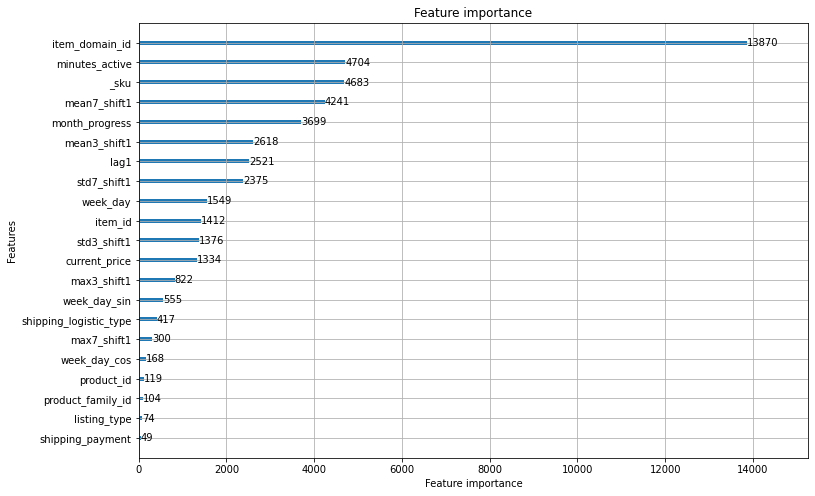

Elapsed time for training the model: 2.126337019602458 min.


{'rmsse_AVG': 0.774191061501472,
 'rmsse_MLA': 0.7652247343123193,
 'rmsse_MLB': 0.8011499644841976,
 'rmsse_MLM': 0.7561984857078993}

In [14]:
models_by_site = list()
sites = ["MLA","MLB","MLM"]

for site in sites:
    print("-"*90)
    print(f"Preparing model for site: {site}")

    tic = time.time()
    train_data = dataset.query("site_id == @site").reset_index(drop=True)
    valid_idx = train_data.query("ds > '2021-03-01'").index

    model = LightGBMForecaster(**model_kwargs)
    model.prepare_features(train_data, valid_idx)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
    model.fit(fit_kwargs={"verbose_eval":50, "feval":evaluator.evaluate})
    lgb.plot_importance(model.model.model, figsize=(12,8))
    plt.show()
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

errors = list()
sites = ["MLA","MLB","MLM"]
for site,model in zip(sites,models_by_site):
    error = model.model.model.best_score["valid_0"]["rmsse"]
    errors.append(error)
result = {
    "rmsse_MLA":errors[0], 
    "rmsse_MLB":errors[1],
    "rmsse_MLM":errors[2],
    "rmsse_AVG":np.mean(errors),
}
display(result)

In [15]:
%%time
all_preds = list()
for site,model in zip(sites,models_by_site):
    preds = model.predict(dataset.query("site_id==@site & ds<='2021-03-01'"))
    all_preds.append(preds)
train_preds = pd.concat(all_preds, axis=0, ignore_index=True)

CPU times: user 12min 45s, sys: 3.9 s, total: 12min 49s
Wall time: 1min 11s


In [16]:
train_preds = pd.merge(train_preds, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
train_preds["sq_error"] = train_preds.eval("(y-y_pred)**2")
train_errors = np.sqrt(train_preds.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
train_errors = pd.merge(train_errors, scales, how="inner", on="sku")
train_errors["rmsse"] = train_errors.eval("rmse/scale")
display(train_errors.groupby("site_id")["rmsse"].mean())
train_errors = train_errors.set_index("sku")

site_id
MLA    0.669543
MLB    0.682535
MLM    0.709587
Name: rmsse, dtype: float64

In [17]:
%%time
all_preds = list()
for site,model in zip(sites,models_by_site):
    print("Preds for site:", site)
    preds = model.predict(dataset.query("site_id==@site & ds>'2021-03-01'"), recursive=True)
    all_preds.append(preds)
oof = pd.concat(all_preds, axis=0, ignore_index=True)

Preds for site: MLA
Preds for site: MLB
Preds for site: MLM
CPU times: user 17min 18s, sys: 47.1 s, total: 18min 5s
Wall time: 28min 4s


In [18]:
mrg = pd.merge(oof, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
mrg["sq_error"] = mrg.eval("(y-y_pred)**2")
valid_errors = np.sqrt(mrg.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
valid_errors = pd.merge(valid_errors, scales, how="inner", on="sku")
valid_errors["rmsse"] = valid_errors.eval("rmse/scale")
valid_errors.groupby("site_id")["rmsse"].mean()

site_id
MLA    0.771351
MLB    0.814717
MLM    0.769492
Name: rmsse, dtype: float64

In [19]:
train_errors.to_csv(f"{results_path}/train_errors_lgbm-m1.csv", index=False)
oof.to_csv(f"{results_path}/oof_preds_lgbm-m1.csv", index=False)

In [20]:
class InventoryDaysPredictor():

    def __init__(self, train, train_errors):
        self.train = train.copy(deep=True)
        self.train_errors = train_errors.copy(deep=True)

    def fit(self, preds):
        parameters = self.train.groupby('sku').agg({'y':['mean', 'std']}).y
        # replace nan means by overall mean
        idx = parameters[parameters["mean"].isna()].index
        parameters.loc[idx, "mean"] = parameters["mean"].mean()
        # replace zero means by overall mean
        idx = parameters[parameters["mean"] == 0].index
        parameters.loc[idx, "mean"] = parameters["mean"].mean()
        
        # replace nan stds by overall std
        idx = parameters[parameters["std"].isna()].index
        parameters.loc[idx,"std"] = parameters["std"].mean()
        # replace nan stds by overall std
        idx = parameters[parameters["std"] == 0].index
        parameters.loc[idx,"std"] = parameters["std"].mean()
        
        self.parameters = parameters.to_dict()

        predictors = dict()
        days = np.arange(1,31)
        for sku,df in tqdm(preds.groupby("sku")):
            cumpred = df.y_pred.values.cumsum()
            interp = interpolate.interp1d(cumpred, days, bounds_error=False, fill_value=(-np.inf,np.inf))
            predictors[sku] = interp
        self.predictors = predictors

    def predict(self, sku, stock):
        mean = self.parameters['mean'][sku]
        std = self.parameters['std'][sku]
        days_to_stockout = float(np.clip(self.predictors[sku](stock), a_min=1, a_max=30))
        std_days = std/mean
        return days_to_stockout,std_days

    def predict_proba(self, sku, stock, dist_kwargs, lambda1, lambda2):
        days_to_stockout,std_days = self.predict(sku, stock)
        scale = std_days * (lambda1*(days_to_stockout**lambda2))
        days = np.arange(1,31)
        probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, **dist_kwargs)
        #if prob is zero, replace with uniform
        if np.sum(probs) == 0: return np.ones(30) / 30
        return probs/np.sum(probs)

In [21]:
predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"), train_errors)
predictor.fit(oof)

100%|██████████| 496797/496797 [01:20<00:00, 6167.47it/s]


***
## Assessment of invetory days prediction

In [22]:
valid = pd.read_csv(f"{input_path}/validation_seed2.csv")

preds = list()
for sku,df in tqdm(valid.groupby("sku")):
    preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
preds = pd.DataFrame(preds, columns=["days_to_stockout"])

100%|██████████| 496797/496797 [01:24<00:00, 5901.88it/s]


RMSE (mean):  10.419674884199948
RMSE (median):  5.8009931146635285
MAE (mean):  7.781241086132508
MAE (median):  5.8009931146635285


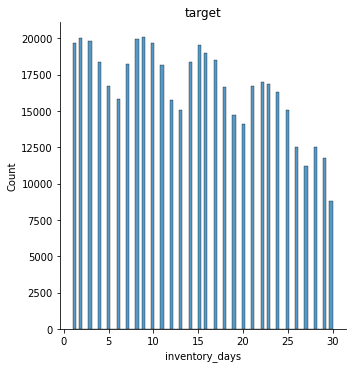

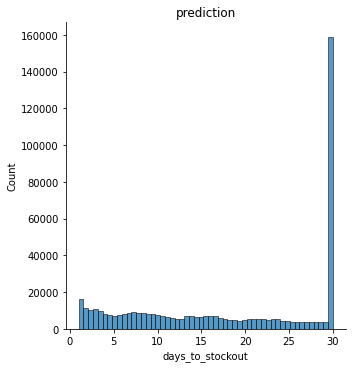

In [23]:
print("RMSE (mean): ", np.sqrt(np.mean((preds.days_to_stockout - valid.inventory_days)**2)) )
print("RMSE (median): ", np.sqrt(np.median((preds.days_to_stockout - valid.inventory_days)**2)) )
print("MAE (mean): ", np.mean(np.abs(preds.days_to_stockout - valid.inventory_days)))
print("MAE (median): ", np.median(np.abs(preds.days_to_stockout - valid.inventory_days)))

sns.displot(valid.inventory_days)
plt.title("target")
plt.show()

sns.displot(preds.days_to_stockout)
plt.title("prediction")
plt.show()

***
## Assessment of RPS

In [24]:
beta = 0.634505
lambda1 = 0.458712
lambda2 = 0.967726

In [25]:
valid_files = [fn for fn in glob(f"{input_path}/validation_seed*.csv") if "seed2.csv" not in fn]
results = list()

for files in valid_files:
    valid = pd.read_csv(files)
    
    preds_proba = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds_proba.append(predictor.predict_proba(
            sku, 
            stock=df.target_stock.values[0],
            dist_kwargs={"beta":beta},
            lambda1=lambda1, 
            lambda2=lambda2,
        ))
    preds_proba = np.array(preds_proba)
    
    rps = scoring_function(valid.inventory_days.values, preds_proba)
    results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
    print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

100%|██████████| 496797/496797 [03:17<00:00, 2511.49it/s]


{'file': 'validation_seed19', 'rps': 3.923348364130472}


100%|██████████| 496797/496797 [03:16<00:00, 2530.21it/s]


{'file': 'validation_seed17', 'rps': 3.926769382005251}


100%|██████████| 496797/496797 [03:17<00:00, 2518.81it/s]


{'file': 'validation_seed23', 'rps': 3.924985480257808}


In [26]:
pd.DataFrame(results)

,file,rps
0,validation_seed19,3.923348
1,validation_seed17,3.926769
2,validation_seed23,3.924985


In [28]:
# cleanup ram
del models_by_site
gc.collect()

0

***
## model training

In [29]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")

dataset = (
    pd.read_parquet(f"{input_path}/train.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(dataset)/1e6)
print("nskus:", dataset.sku.nunique())

nrows: 36.594396
nskus: 635633


In [30]:
test = (
    pd.read_parquet(f"{input_path}/test.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds",}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(test)/1e6)
print("nskus:", test.sku.nunique())

nrows: 15.78567
nskus: 526189


------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 372.71 Mb (45.7% reduction)
Elapsed time for processing features: 1.3705147743225097 min.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 3164181, number of used features: 21


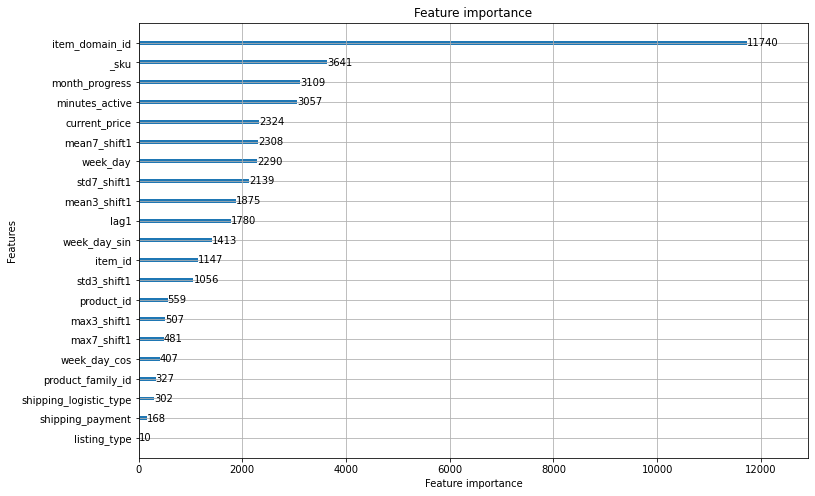

Elapsed time for training the model: 0.3727463722229004 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 2404.36 Mb (43.1% reduction)
Elapsed time for processing features: 6.633098483085632 min.
[LightGBM] [Info] Total Bins 3163
[LightGBM] [Info] Number of data points in the train set: 18687512, number of used features: 21


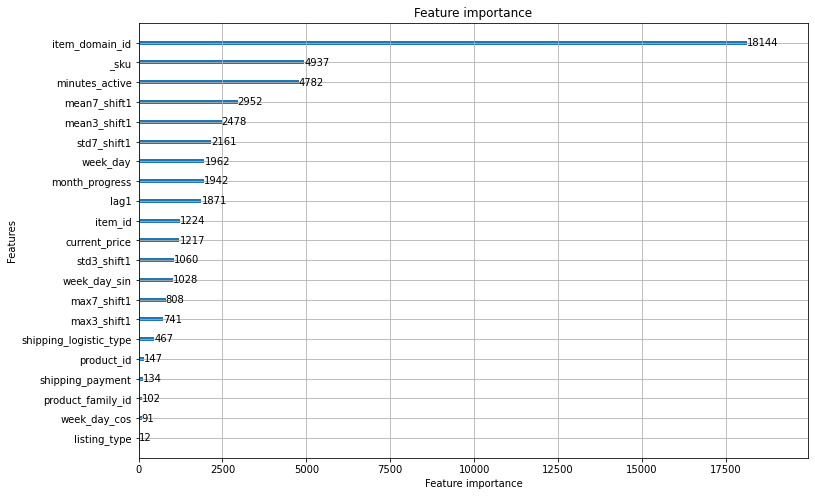

Elapsed time for training the model: 1.914529232184092 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM


In [ ]:
models_by_site = list()
sites = [
    "MLA",
    "MLB",
    "MLM",
]
num_iterations = {
    "MLA": 160,
    "MLB": 190,
    "MLM": 190,
}

for site in sites:
    print("-"*90)
    print(f"Preparing model for site: {site}")

    tic = time.time()
    train_data = dataset.query("site_id == @site").reset_index(drop=True)
    
    _model_kwargs = dict(model_kwargs)
    _model_kwargs["model_params"]["num_iterations"] = num_iterations[site]

    model = LightGBMForecaster(**_model_kwargs)
    model.prepare_features(train_data)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    model.fit()
    lgb.plot_importance(model.model.model, figsize=(12,8))
    plt.show()
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")


In [ ]:
preds_by_site = list()

for site,model in tqdm(zip(sites,models_by_site)):
    preds = model.predict(test.query("site_id == @site"), recursive=True)
    preds_by_site.append(preds)
    
predictions = pd.concat(preds_by_site, ignore_index=True)

In [ ]:
# todo: fix train_errors
predictor = InventoryDaysPredictor(dataset, train_errors)
predictor.fit(predictions)

In [ ]:
stockout_preds = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    stockout_preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
stockout_preds = pd.DataFrame(stockout_preds, columns=["days_to_stockout"])

sns.displot(stockout_preds.days_to_stockout)
plt.title("stockout predictions")
plt.show()

In [ ]:
print(beta, lambda1, lambda2)
std_days = np.mean(np.asarray(list(predictor.parameters["std"].values())) / np.asarray(list(predictor.parameters["mean"].values())))

for days_to_stockout in range(1,31):
    scale = std_days * (lambda1*(days_to_stockout**lambda2))
    days = np.arange(1,31)
    probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=beta)
    
    plt.plot(days, probs)
    plt.grid()
    plt.title(f"days_to_stockout={days_to_stockout}")
    plt.show()

In [ ]:
skus = list()
preds_proba = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    skus.append(sku)
    preds_proba.append(predictor.predict_proba(
        sku, 
        stock=df.target_stock.values[0],
        dist_kwargs={"beta":beta},
        lambda1=lambda1, 
        lambda2=lambda2,
    ))
preds_proba = np.array(preds_proba)
preds_proba = pd.DataFrame(preds_proba, index=skus)

In [ ]:
unpreds_proba = np.ones((len(unpredictable),30)) / 30
unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
preds_proba_mrg

***
## generate submission

In [ ]:
test = pd.read_csv(f"{input_path}/test_data.csv")
preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [ ]:
assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
assert preds_proba_mrg.max(axis=1).max() < 1

In [ ]:
(preds_proba_mrg
 .round(4)
 .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
)

***